In [104]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
# plot graphics in the notebook, not in a separate external window.

## objects

# NN

In [119]:
import scipy.special
import scipy.misc
# helper to load data from PNG image files
import imageio
# glob helps select multiple files using patterns
import glob

In [128]:
# neural network class definition
class neuralNetwork:
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set the number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # mean; standard deviation; shape
        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        # lambda: define a function, name is before '='
        self.activation_function = lambda x: scipy.special.expit(x)
    
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate signals emerging fron hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate signals emerging fron hidden layer
        final_outputs = self.activation_function(final_inputs) 
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.who.T, output_errors)
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
      
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate signals emerging fron hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate signals emerging fron hidden layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [118]:
# number of input, hidden and output nodes
input_nodes = 784  # 28*28 pixels
hidden_nodes = 250  # less than 784, but not too small(there is no perfect method for choosing hidden nodes and layer)
output_nodes = 10  # 10 labels

# learning rate
learning_rate = 0.1

# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# loading the mnist training data CSV file into a list
training_data_file = open("E:\download\MNIST\mnist_train.csv", 'r') # r:read only
training_data_list = training_data_file.readlines() # for big file, don't usereadlines()(reads the entire file into memory)
training_data_file.close() # good habit

# train the neural network

# epochs is the number of times the training data set is used for training
epoch = 5

for e in range(epoch):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs to range 0.01 to 1.00
        inputs = (np.asfarray(all_values[1:]) / 255 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = np.zeros(output_nodes) + 0.01
        # all values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
    
# load the mnist test data CSV file into a list
test_data_file = open("E:\download\MNIST\mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

# test the neural network

# scorecard for how well the network performs, initially empty
scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is the first value
    correct_label = int(all_values[0])
    # print(correct_label, "correct label")
    # scale and shift the inputs to range 0.01 to 1.00
    inputs = (np.asfarray(all_values[1:]) / 255 * 0.99) + 0.01
    # query the network
    outputs = n.query(inputs)
    # the index of the highest value corresponds to the label 
    label = np.argmax(outputs)
    # print(label, "network's answer")
    # append correct or incorrect to list
    if label == correct_label:
        # network's annswer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        
# print(scorecard)
# calculate the performance score, the fraction of correct answers 
scorecard_array = np.asarray(scorecard)
print("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.9712


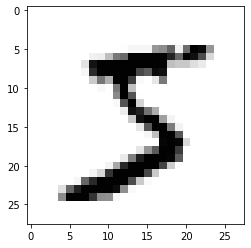

In [113]:
# plot
all_values = data_list[0].split(',') # delete the comma
# [1:] take all except the 1st element of this list
# .asfarray: convert text strings into real numbers
# reshape: convert 784 to 28*28
image_array = np.asfarray(all_values[1:]).reshape((28,28)) 
plt.imshow(image_array, cmap='Greys', interpolation='None')

7


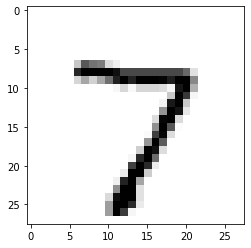

In [114]:
# get the first test record
all_values = test_data_list[0].split(',')
# print the label
print(all_values[0])

image_array = np.asfarray(all_values[1:]).reshape((28,28))
plt.imshow(image_array, cmap='Greys', interpolation='None')

In [115]:
n.query((np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01)

array([[0.0204121 ],
       [0.00433313],
       [0.00243854],
       [0.0052142 ],
       [0.0023806 ],
       [0.00994541],
       [0.0157581 ],
       [0.9871998 ],
       [0.00454907],
       [0.02647128]])

## use your own images

In [ ]:
# image_file_name
# get data from PNG or JPG
# flatten:turns the image into simple array of float numbers; also flatten color values into grey scale
img_array = scipy.misc.imread(image_file_name, flatten=True)  

# reshape the array from 28*28 square into a longlist of values
# 255- : image(0:black, 255:white); MNIST(0:white, 255:black)
img_data = 255.0 - img_array.reshape(784)
# range from 0.01 to 1.00
img_data = (img_data / 255.0 / 0.99) + 0.01

In [ ]:
# our own image test data set
our_own_dataset = []

# load the png image data as test data set
for image_file_name in glob.glob('my_own_images/2828_my_own_?.png'):
    
    # use the filename to set the correct label
    label = int(image_file_name[-5:-4])
    
    # load image data from png files into an array
    print ("loading ... ", image_file_name)
    img_array = imageio.imread(image_file_name, as_gray=True)
    
    # reshape from 28x28 to list of 784 values, invert values
    img_data  = 255.0 - img_array.reshape(784)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    print(numpy.min(img_data))
    print(numpy.max(img_data))
    
    # append label and image data  to test data set
    record = numpy.append(label,img_data)
    our_own_dataset.append(record)
    
    pass

In [ ]:
# test the neural network with our own images

# record to test
item = 2

# plot image
matplotlib.pyplot.imshow(our_own_dataset[item][1:].reshape(28,28), cmap='Greys', interpolation='None')

# correct answer is first value
correct_label = our_own_dataset[item][0]
# data is remaining values
inputs = our_own_dataset[item][1:]

# query the network
outputs = n.query(inputs)
print (outputs)

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("network says ", label)
# append correct or incorrect to list
if (label == correct_label):
    print ("match!")
else:
    print ("no match!")
    pass

## backquery

In [ ]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 0
# create the output signals for this label
targets = np.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
plt.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

## rotation

In [ ]:
# create rotate variations
# rotated anticlockwise by 10 degrees
# cval: fill 0.01 in array elements because they didn't exist in the original image
inputs_plus10_img = scipy.ndimage.interpolation.rotate(scaled_input_reshape(28,28), 10, cval=0.01, reshape=False)
# rotated clockwise by 10 degrees
inputs_plus10_img = scipy.ndimage.interpolation.rotate(scaled_input_reshape(28,28), -10, cval=0.01, reshape=False)
